In [9]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Database connection details
load_dotenv("creds.env")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

# Create connection
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")


In [11]:
customers_df = pd.read_sql("SELECT * FROM customers", engine)
orders_df = pd.read_sql("SELECT * FROM orders", engine)
payments_df = pd.read_sql("SELECT * FROM payments", engine)
products_df = pd.read_sql("SELECT * FROM products", engine)
sellers_df = pd.read_sql("SELECT * FROM sellers", engine)
order_items_df = pd.read_sql("SELECT * FROM order_items", engine)
# orders_df.head()

In [12]:
query = """ 
    SELECT o.order_id,
        o.customer_id,
        o.order_purchase_timestamp,
        p.payment_value,
        oi.product_id,
        oi.seller_id,
        pr.product_category_name,
        c.customer_unique_id
    FROM orders o
        LEFT JOIN payments p ON o.order_id = p.order_id
        LEFT JOIN order_items oi ON o.order_id = oi.order_id
        LEFT JOIN products pr ON oi.product_id = pr.product_id
        LEFT JOIN customers c ON o.customer_id = c.customer_id
        LEFT JOIN sellers s ON oi.seller_id = s.seller_id;
"""

main_df = pd.read_sql(query, engine)

print(main_df.head())

                           order_id                       customer_id  \
0  001d8f0e34a38c37f7dba2a37d4eba8b  d987da9fb4086ab7c2c0f83963cd6722   
1  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
2  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
3  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
4  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   

  order_purchase_timestamp  payment_value                        product_id  \
0      2017-05-14 17:19:44          53.54  e67307ff0f15ade43fcb6e670be7a74c   
1      2017-09-13 08:59:02          72.19  4244733e06e7ecb4970a6e2683c13e61   
2      2017-04-26 10:53:06         259.83  e5f2d52b802189ee658865ca93d83a8f   
3      2018-01-14 14:33:31         216.87  c777355d18b72b67abbeef9df44fd0fd   
4      2018-08-08 10:00:35          25.78  7634da152a4610f1595efa32f14722fc   

                          seller_id product_category_name  \
0  f4aba7c0bca51484c30ab7

In [ ]:
# Check missing values
print(main_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  118434 non-null  object        
 1   customer_id               118434 non-null  object        
 2   order_purchase_timestamp  118434 non-null  datetime64[ns]
 3   payment_value             118431 non-null  float64       
 4   product_id                117604 non-null  object        
 5   seller_id                 117604 non-null  object        
 6   product_category_name     117604 non-null  object        
 7   customer_unique_id        118434 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 7.2+ MB
None
                                order_id                       customer_id  \
count                             118434                            118434   
unique                      

In [15]:
# very few null values/ we can keep if we want as they as cleaning already performed using SQL
# they exist for a reason :
#   payment_value (3 nulls)
#   Could mean orders without payment recorded (canceled, failed, or data issue).
# product_id, seller_id, product_category_name (830 nulls each)
# Likely orders that don’t have items mapped (maybe canceled orders, or missing product mapping).
# focus = sales analysis, these rows don’t add value (no product, no seller → can’t aggregate sales).
# therefore, dropping nulls

clean_df = main_df.dropna(subset=['product_id', 'seller_id', 'product_category_name', 'payment_value'])
clean_df.isna().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
payment_value               0
product_id                  0
seller_id                   0
product_category_name       0
customer_unique_id          0
dtype: int64

In [17]:
print(clean_df.shape)

(117601, 8)


In [ ]:
# stats of payment_value
clean_df['payment_value'].describe()

count    117601.000000
mean        172.686752
std         267.592290
min           0.000000
25%          60.870000
50%         108.210000
75%         189.260000
max       13664.080000
Name: payment_value, dtype: float64

In [ ]:
# 74 product categories
clean_df['product_category_name'].unique().__len__()

74

<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='order_purchase_timestamp'>

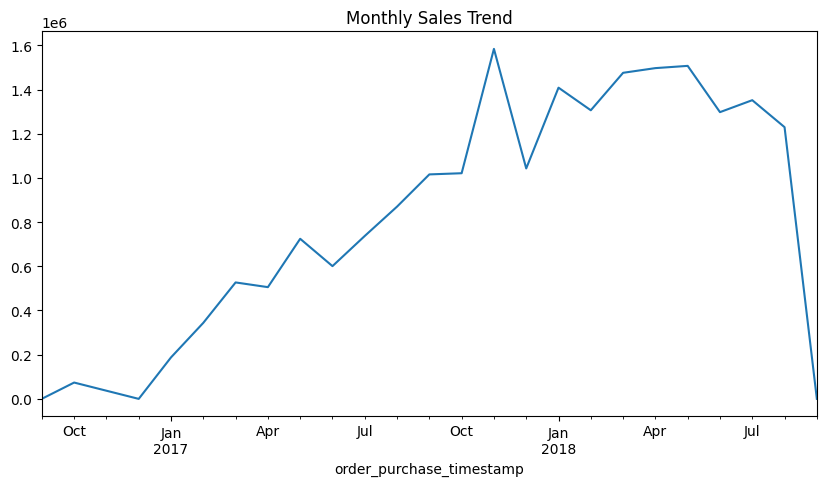

In [29]:
sales_trend = clean_df.groupby(clean_df['order_purchase_timestamp'].dt.to_period("M"))['payment_value'].sum()
sales_trend.plot(figsize=(10,5), title="Monthly Sales Trend")


In [30]:
# top products
top_products = main_df.groupby('product_category_name')['payment_value'].sum().sort_values(ascending=False).head(10)
print(top_products)


product_category_name
cama_mesa_banho           1712553.67
beleza_saude              1657373.12
informatica_acessorios    1585330.45
moveis_decoracao          1430176.39
relogios_presentes        1429216.68
esporte_lazer             1392127.56
utilidades_domesticas     1094758.13
automotivo                 852294.33
ferramentas_jardim         838280.75
cool_stuff                 779698.00
Name: payment_value, dtype: float64
